In [1]:
import torch
import math

import torch.nn.functional as F

from dataset.semantic_segmentation_dataset import LoFiSemanticDataset

from model.image_encoder import ImageEncoder
from model.semantic_mask_decoder import MaskDecoder
from model.location_encoder import LocationEncoder

import matplotlib.pyplot as plt
import numpy as np
import cv2

/home/aghosh57/.conda/envs/lofi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from config import cfg

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [4]:
class LoFiModel(torch.nn.Module):
    def __init__(self, cfg, device):
        super(LoFiModel, self).__init__()

        self.image_encoder = ImageEncoder(image_size=cfg.DATA.IMAGE.SIZE, num_channels=cfg.DATA.IMAGE.CHANNELS, freeze=True)

        self.location_encoder = LocationEncoder(embedding_size=256, freeze=True)

        self.mask_decoder = MaskDecoder(input_channels=769, out_channels=1)

        if cfg.MODEL.SS.CHECKPOINT_PATH:
            state_dict = torch.load(cfg.MODEL.SS.CHECKPOINT_PATH)["state_dict"]
            # only load the image encoder weights and not the decoder weights
            image_encoder_state_dict = {k.replace("image_encoder.", ""): v for k, v in state_dict.items() if k.startswith("image_encoder")}
            location_encoder_state_dict = {k.replace("location_encoder.", ""): v for k, v in state_dict.items() if k.startswith("location_encoder")}
            mask_decoder_state_dict = {k.replace("mask_decoder.", ""): v for k, v in state_dict.items() if k.startswith("mask_decoder")}

            self.image_encoder.load_state_dict(state_dict=image_encoder_state_dict)
            self.location_encoder.load_state_dict(state_dict=location_encoder_state_dict)
            self.mask_decoder.load_state_dict(state_dict=mask_decoder_state_dict)

        self.device = device

        self.to(device)
    
    @torch.no_grad()
    def forward(self, image, gps):
        image = image.to(self.device)
        gps = gps.to(self.device)

        image_embedding = self.image_encoder(pixel_values=image, bool_masked_pos=None)
        sequence_output = image_embedding[0]
        # Reshape to (batch_size, num_channels, height, width)
        sequence_output = sequence_output.transpose(1, 2)
        batch_size, num_channels, sequence_length = sequence_output.shape
        height = width = math.floor(sequence_length**0.5)
        sequence_output = sequence_output.reshape(batch_size, num_channels, height, width)

        # Get the GPS features from the location encoder
        gps_embedding = self.location_encoder(gps)
        gps_embedding = F.normalize(gps_embedding, dim=1)
        gps_embedding = gps_embedding.reshape(batch_size, 1, height, width)

        # Concatenate the image and GPS embeddings
        joint_embedding = torch.cat([sequence_output, gps_embedding], dim=1)

        mask_logits = self.mask_decoder(joint_embedding)

        return mask_logits

In [5]:
model = LoFiModel(cfg, device)
model.eval()
print(model)

LoFiModel(
  (image_encoder): ImageEncoder(
    (swinModel): SwinModel(
      (embeddings): SwinEmbeddings(
        (patch_embeddings): SwinPatchEmbeddings(
          (projection): Conv2d(6, 96, kernel_size=(4, 4), stride=(4, 4))
        )
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): SwinEncoder(
        (layers): ModuleList(
          (0): SwinStage(
            (blocks): ModuleList(
              (0-1): 2 x SwinLayer(
                (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                (attention): SwinAttention(
                  (self): SwinSelfAttention(
                    (query): Linear(in_features=96, out_features=96, bias=True)
                    (key): Linear(in_features=96, out_features=96, bias=True)
                    (value): Linear(in_features=96, out_features=96, bias=True)
                    (dropout): Dropout(p=0.0, inplace=False)
 

In [6]:
test_dataset = LoFiSemanticDataset(dataset_path=cfg.DATA.TEST_PATH)

In [7]:
test_dataset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
ious = []
precisions = []
recalls = []
f1_scores = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


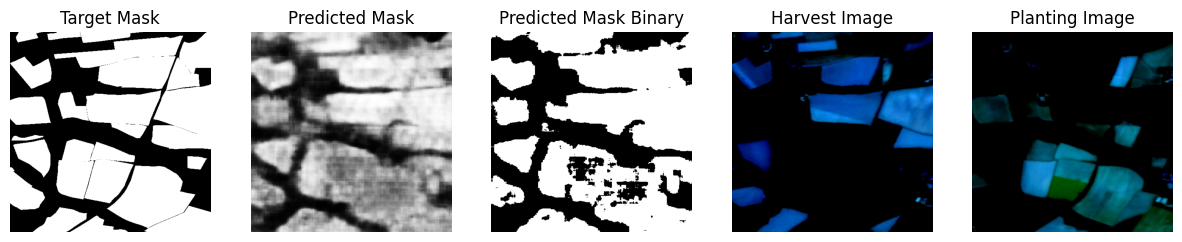

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


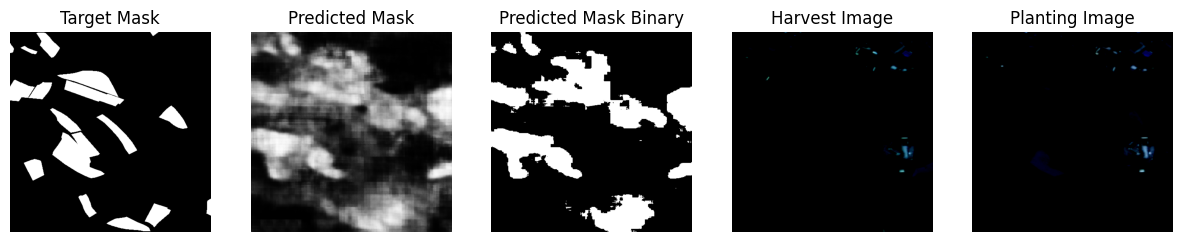

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


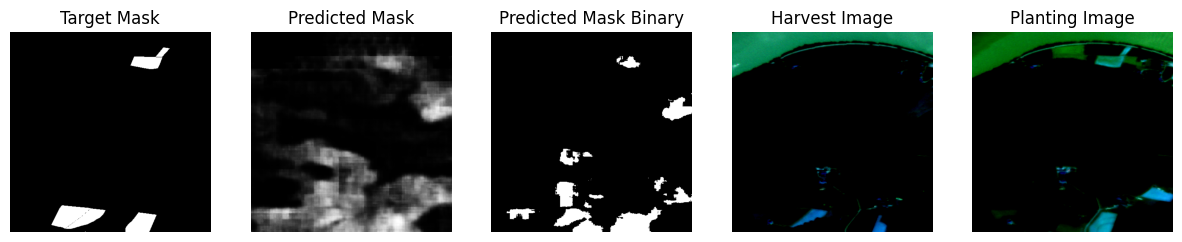

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


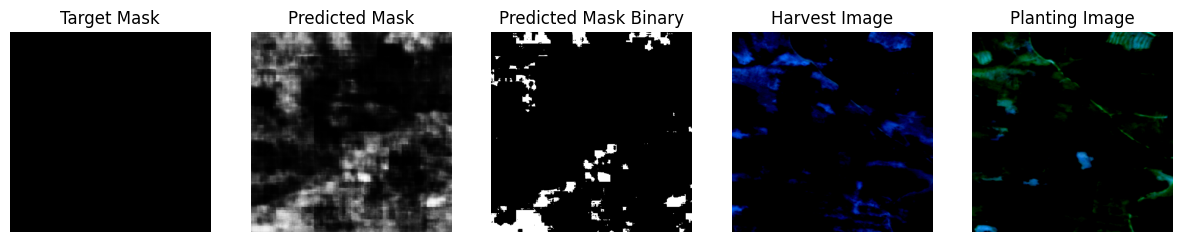

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


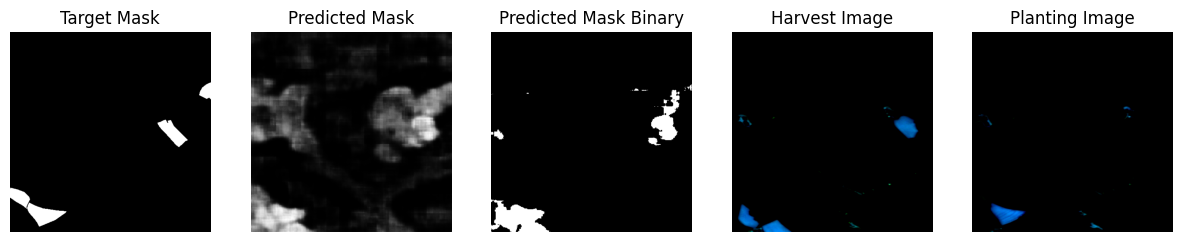

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


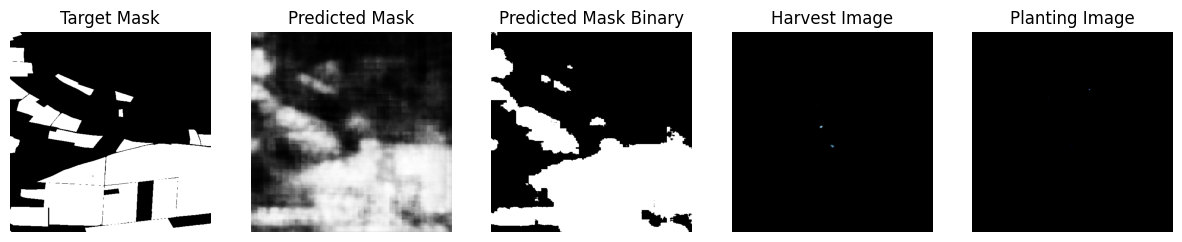

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


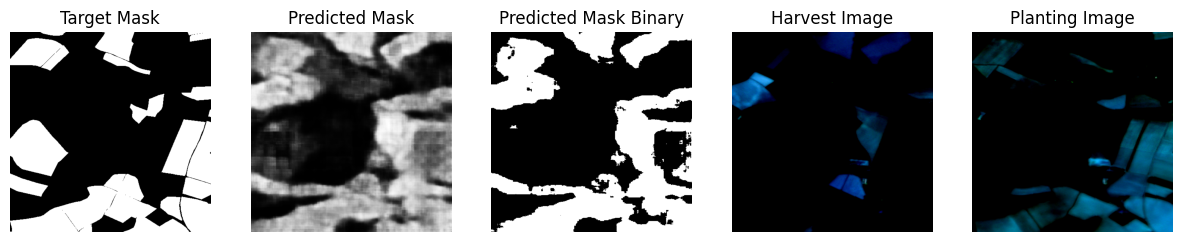

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


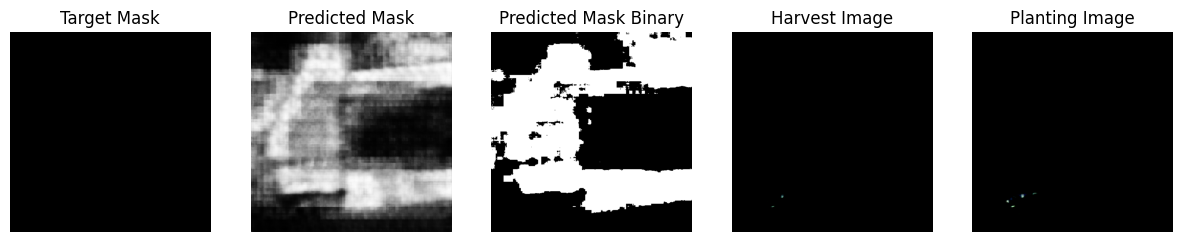

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


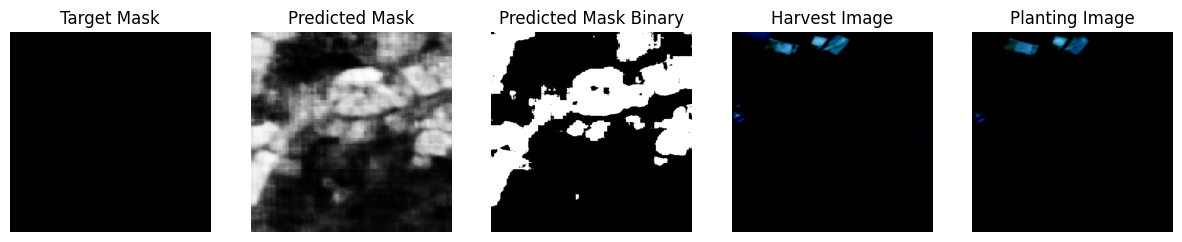

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


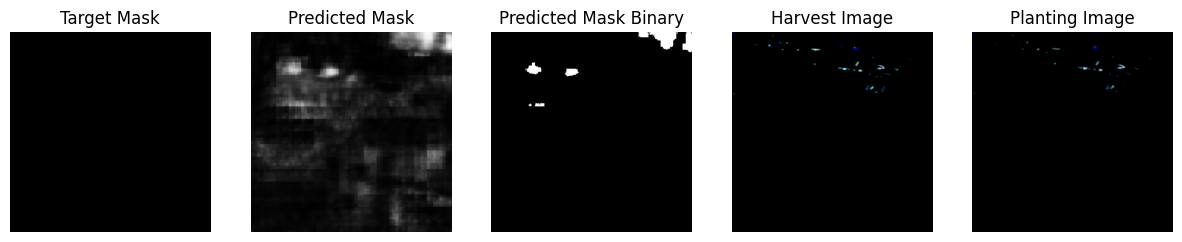

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


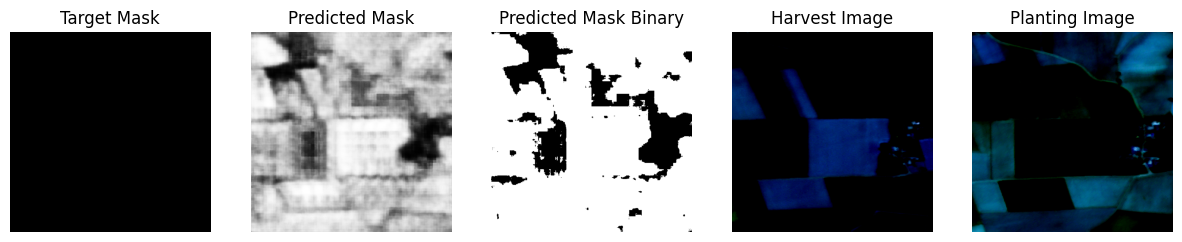

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


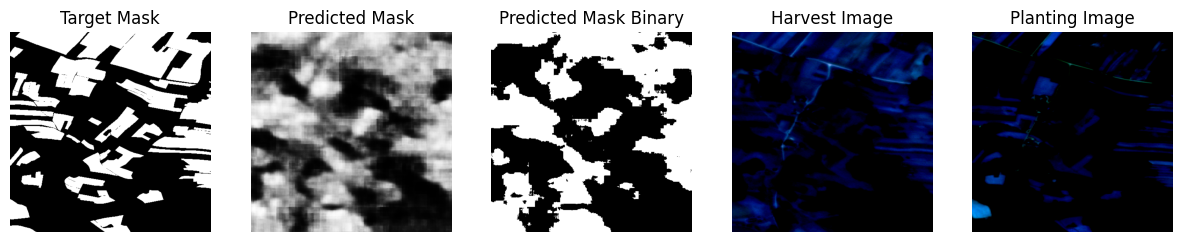

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


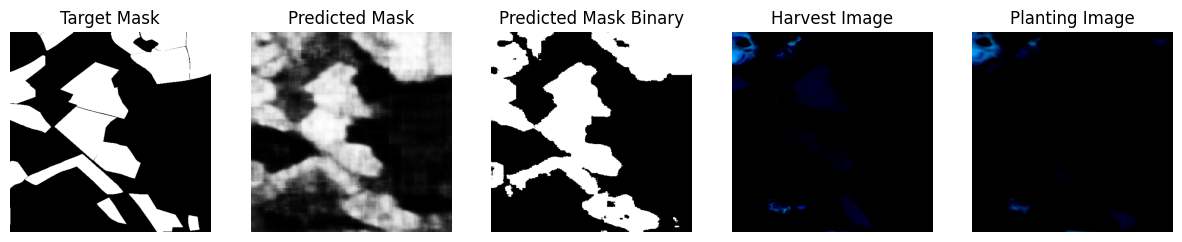

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


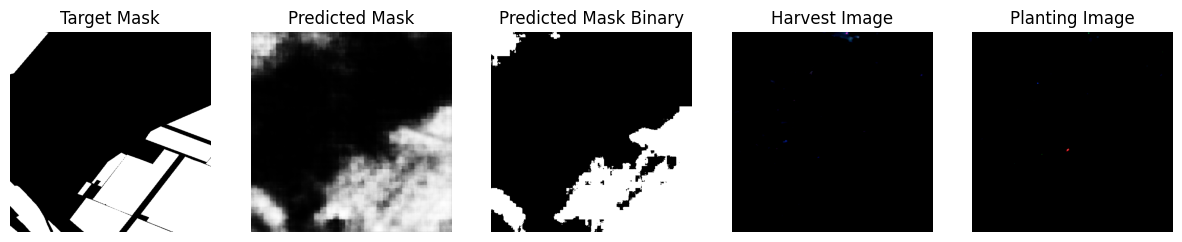

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


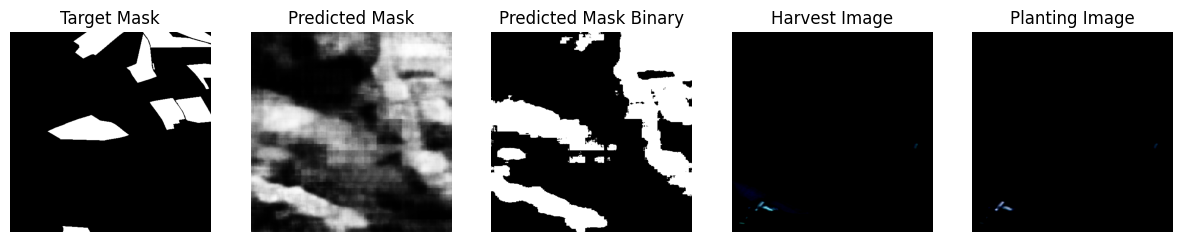

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


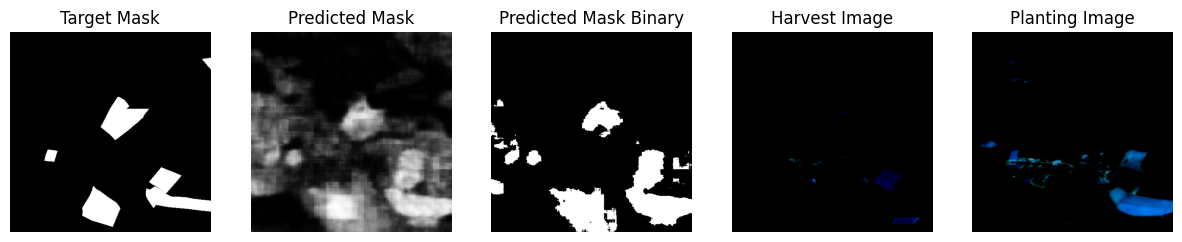

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


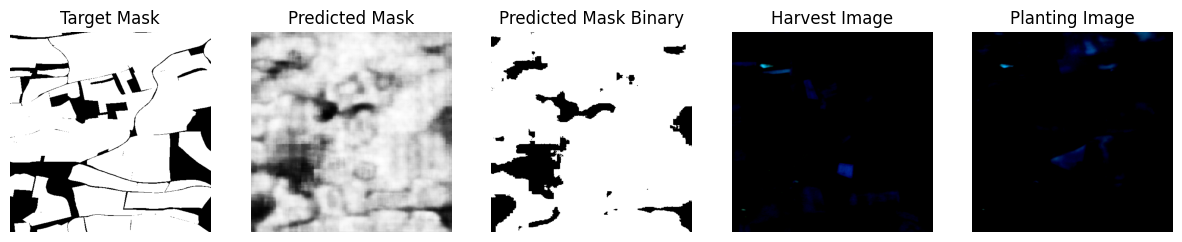

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


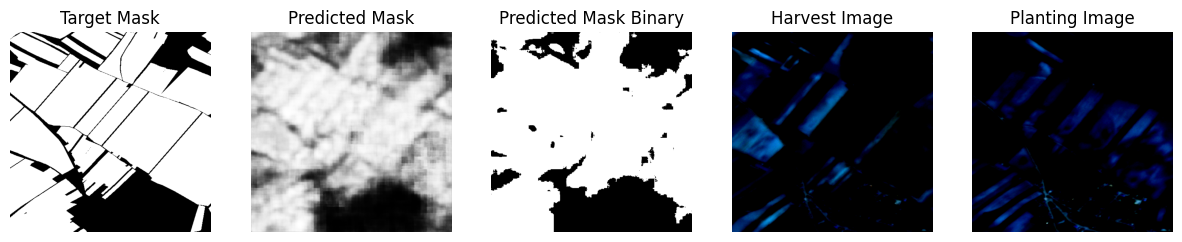

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


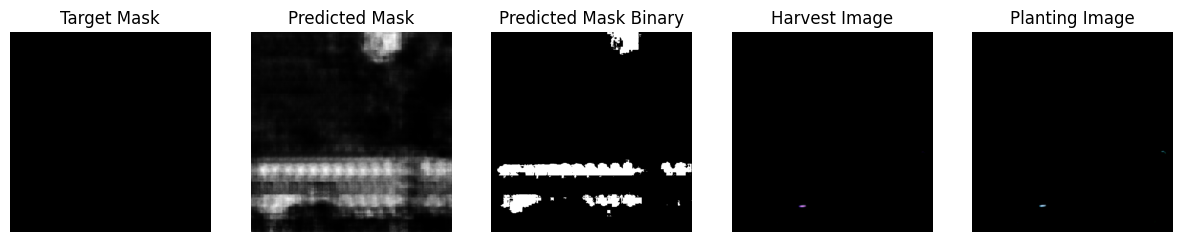

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


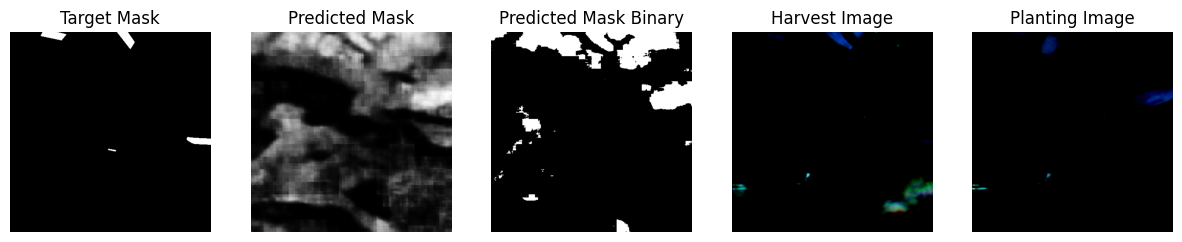

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


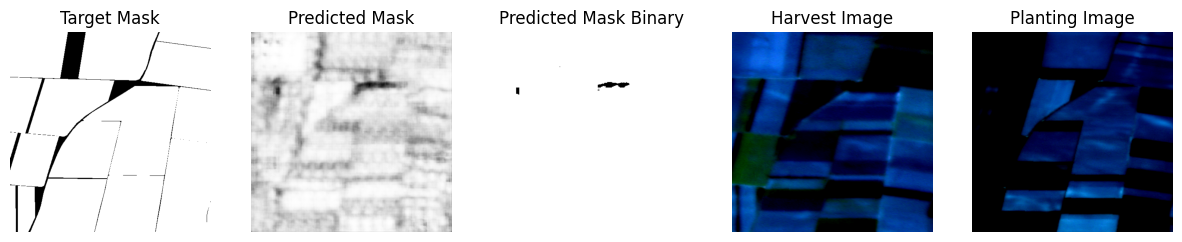

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


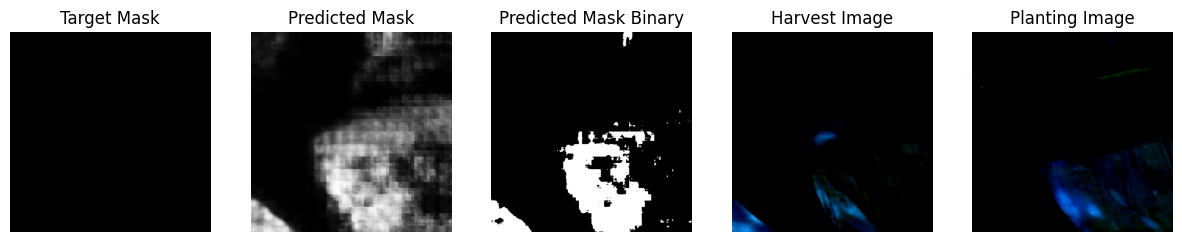

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


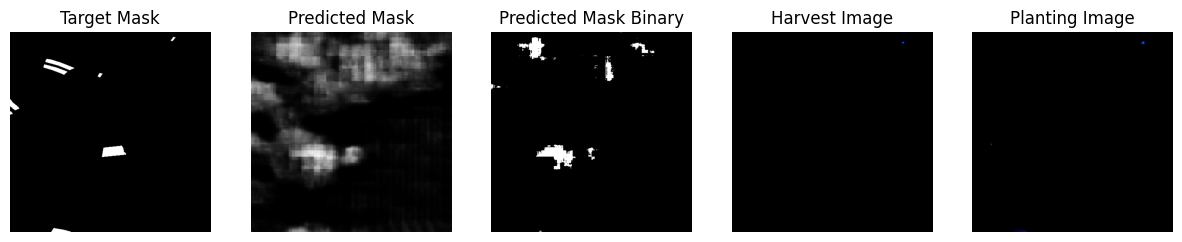

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


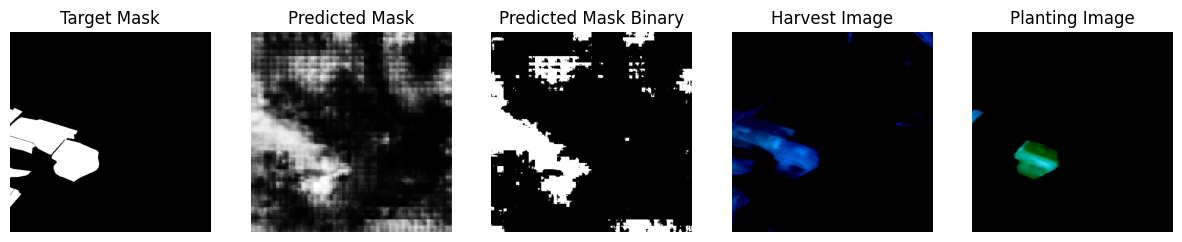

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


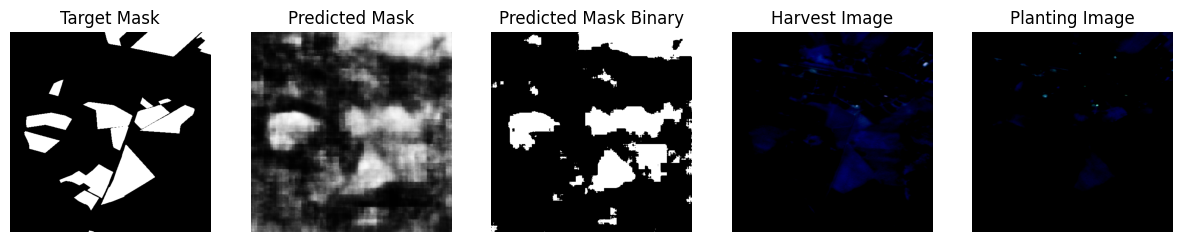

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


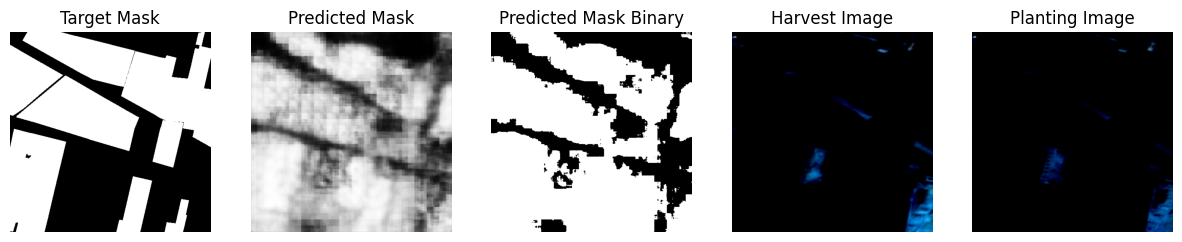

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


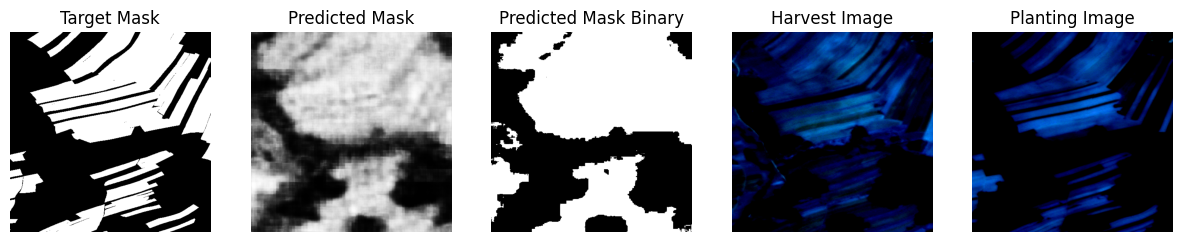

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


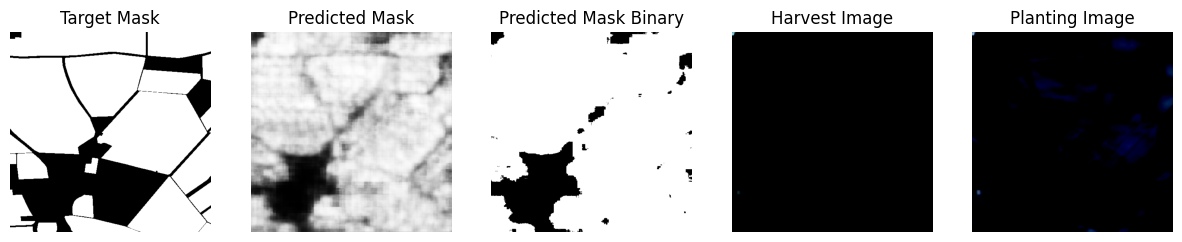

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


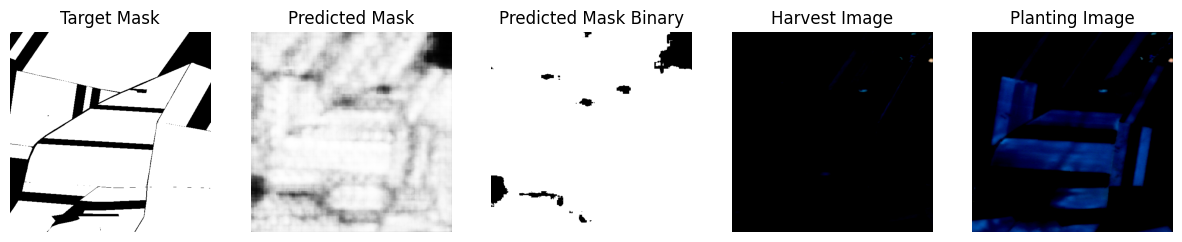

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


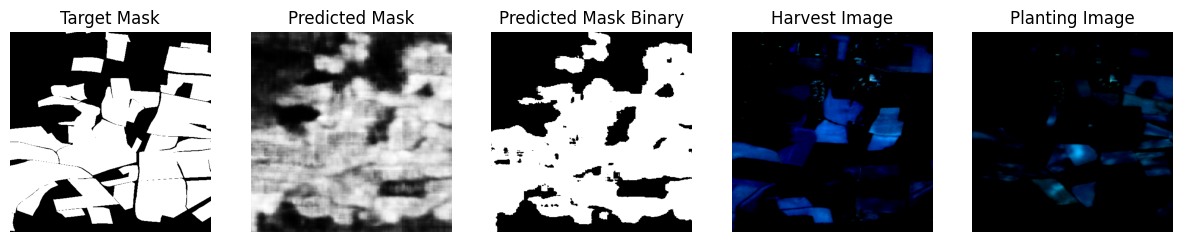

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


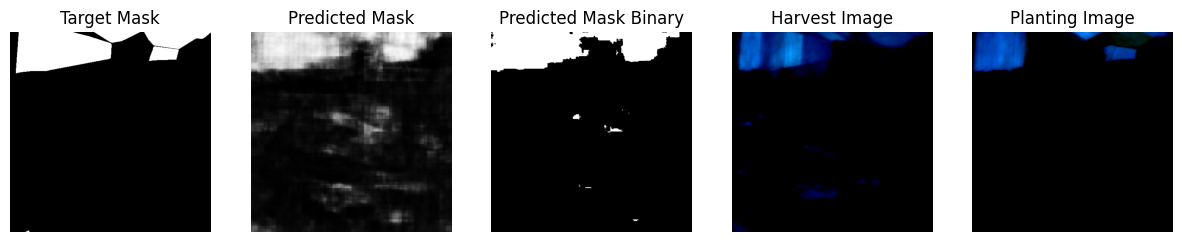

In [9]:
for i, (image, gps, target_masks) in enumerate(test_dataset_loader):
    predicted_masks = model(image, gps)
    predicted_masks = predicted_masks.detach().cpu().numpy().squeeze()
    target_masks = target_masks.detach().cpu().numpy().squeeze()

    predicted_masks_binary = np.where(predicted_masks > 0.5, 1, 0)

    harvest_image = image.squeeze()[0:3, :, :].detach().cpu().numpy().transpose(1, 2, 0)
    planting_image = image.squeeze()[3:6, :, :].detach().cpu().numpy().transpose(1, 2, 0)

    #plot the predicted masks and target masks
    plt.subplots(1, 5, figsize=(15, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(target_masks, cmap="gray")
    plt.title("Target Mask")
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.imshow(predicted_masks, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(predicted_masks_binary, cmap="gray")
    plt.title("Predicted Mask Binary")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(harvest_image)
    plt.title("Harvest Image")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(planting_image)
    plt.title("Planting Image")
    plt.axis("off")

    plt.show()
    
    if i == 30:
        break